# Task 3: Predictive Analysis

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve

In [13]:
customer_profile = pd.read_csv('../dataset/customer_profile_kmeans.csv', sep='\t', index_col=0)
customer_profile

,I,Iu,Imax,E,Savg,R,F,M,label
CustomerID,,,,,,,,,
12747.0,0.870894,0.017546,-0.038273,0.554838,0.336561,-0.500054,0.512319,1.268486,low
12748.0,3.043268,3.259964,2.254020,0.477904,-0.675782,-1.680426,3.536461,2.969024,low
12749.0,1.207900,1.196320,1.546322,0.487578,1.414379,-0.500054,1.134077,1.463197,low
12820.0,0.746231,0.533552,0.549481,0.286244,0.292491,-0.043259,0.425503,0.587988,low
12821.0,-1.026156,-1.441491,-0.802301,-0.908067,-1.156208,0.473247,-1.441955,-1.426696,medium
...,...,...,...,...,...,...,...,...,...
18280.0,-1.436179,-1.051384,-1.363713,-1.031709,-0.385789,0.821730,-1.083852,-0.949103,medium
18281.0,-1.233447,-1.441491,-1.086128,-1.070446,-1.778062,-1.680426,-1.441955,-1.812192,medium
18282.0,-1.248452,-1.051384,-1.819487,0.028755,-1.535158,1.026516,-1.083852,-1.103305,medium


In [17]:
customer_profile = customer_profile.to_numpy()

In [14]:
def plot_learning_curve(estimator, X, y, scorer='accuracy', cv=5, train_sizes=np.linspace(.1, 1.0, 5), 
                        shuffle=False, random_state=None):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, train_sizes=train_sizes, cv=cv,
                                                            scoring=scorer, n_jobs=-1, shuffle=shuffle,
                                                            random_state=random_state)

    mean_train_score = np.mean(train_scores, axis=1)
    std_train_score = np.std(train_scores, axis=1)
    mean_test_score = np.mean(test_scores, axis=1)
    std_test_score = np.std(test_scores, axis=1)

    plt.title(str(estimator.__class__.__name__) + ' learning curve')
    plt.xlabel('training set size')
    plt.ylabel('score')

    plt.plot(train_sizes, mean_train_score, label='train score', color='navy', marker='.', lw=2)
    plt.fill_between(train_sizes, mean_train_score + std_train_score,
                     mean_train_score - std_train_score, color='navy', alpha=0.2)
    plt.plot(train_sizes, mean_test_score, label='cross-validation score', color='darkorange', marker='.', lw=2)
    plt.fill_between(train_sizes, mean_test_score + std_test_score,
                     mean_test_score - std_test_score, color='darkorange', alpha=0.2)

    plt.legend().get_frame().set_facecolor('white')
    plt.show()
    
def highlight_equal(s, value, column):
    is_max = pd.Series(data=False, index=s.index)
    is_max[column] = s.loc[column] == value
    return ['background-color: lightyellow' if is_max.any() else '' for v in is_max]

## SVC

In [15]:
from sklearn.svm import SVC

In [18]:
X, y = customer_profile[:, :-1], customer_profile[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

tuned_parameters = {'kernel': ('linear', 'poly', 'rbf'),
                    'C': (0.1, 1, 10, 100, 1000)}

grid = GridSearchCV(SVC(),
                    param_grid=tuned_parameters,
                    scoring='accuracy',
                    cv=5,  # 5 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit=True,  # refit the best model on the full development set
                    return_train_score=True,
                    verbose=True).fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:    2.0s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    2.0s finished


In [19]:
df = pd.DataFrame(grid.cv_results_)[['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score')
df.rename(columns={'mean_test_score': 'mean_val_score', 
                   'rank_test_score': 'rank_val_score'}, inplace=True)

df.head(15).style.apply(highlight_equal, value=1, column=['rank_val_score'], axis=1).hide_index()

params,mean_train_score,mean_val_score,rank_val_score
"{'C': 100, 'kernel': 'linear'}",0.999004,0.997102,1
"{'C': 1000, 'kernel': 'linear'}",0.999547,0.996739,2
"{'C': 10, 'kernel': 'linear'}",0.997736,0.995292,3
"{'C': 1, 'kernel': 'linear'}",0.994386,0.992393,4
"{'C': 0.1, 'kernel': 'linear'}",0.991579,0.990944,5
"{'C': 100, 'kernel': 'rbf'}",0.999095,0.990583,6
"{'C': 1000, 'kernel': 'poly'}",0.998823,0.988773,7
"{'C': 10, 'kernel': 'rbf'}",0.995654,0.988045,8
"{'C': 1000, 'kernel': 'rbf'}",1.000000,0.987686,9
"{'C': 1, 'kernel': 'rbf'}",0.992213,0.985873,10


In [20]:
accuracy_score(grid.best_estimator_.predict(X_test), y_test)

0.995656894679696

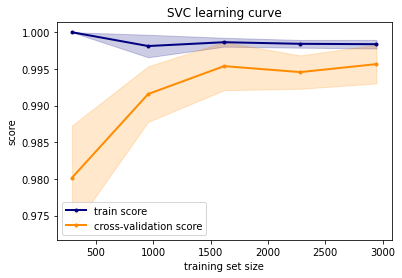

In [21]:
plot_learning_curve(grid.best_estimator_, X, y)

## Random Forest

## Gradient Boosting

## Decision Tree

## K-Nearest Neighbors

## Logistic Regression